# **Quantitative Economics**

# **Problem Set 7**
Parham Mohammadi - 401206677

Sana Rashidi - 401211522

# **30 Value Function Calculation**

In [1]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [2]:
def value_function_iteration(
  F: Callable[[float, float], float],
  beta: float,
  grid: List[float],
  V0: List[float],
  constraint: Callable[[float], Tuple[float, float]],
  steady_x: float=None,
  convergence_eps: float=1e-6,
  max_iter=1000
):
  V_now = np.array(V0)
  V_next = np.zeros_like(V_now)
  V_series = V_now.reshape((1, -1))
  grid=np.array(grid)
  policy_series = np.array(grid).reshape((1, -1))

  def T_operator(x):
    x_min, x_max = constraint(x)
    cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - x_min},
        {'type': 'ineq', 'fun': lambda x: x_max - x[0]}
    )
    res =  minimize(
        lambda y: -(F(x, y[0]) + beta*np.interp(y[0], grid, V_now)),
        policy_series[-1, np.argmin(np.abs(grid-x))],
        constraints=cons,
        method="SLSQP", tol=1e-7
    )
    return -res.fun, res.x[0]

  iter = 0
  while iter == 0 or np.max(np.abs(V_next - V_now)) > convergence_eps:
    V_now = V_series[-1, :]
    vectorized_operator = np.vectorize(T_operator)
    V_next, policy_next = vectorized_operator(grid)
    V_series = np.concatenate(
        [V_series, V_next.reshape((1, -1))], axis=0
    )
    policy_series = np.concatenate(
        [policy_series, policy_next.reshape((1, -1))], axis=0
    )
    iter += 1

    if iter % 50 == 0:
      print(f"Iteration {iter} has finished.")
    elif iter >= max_iter:
      break

  return V_series, policy_series

In [3]:
sigma = 0.2
A = 1
alpha = 0.65
pk = 1
delta = 0.5
beta = 0.8
N = 1000
eps = 1e-5

In [5]:
def F(x, y):
  if x <= 0 or A*(x**alpha) + pk*(1-delta)*x - pk*y <= 0:
    U = 0
  else:
    U = (1/(1-sigma))*((A*(x**alpha) + pk*(1-delta)*x - pk*y)**(1-sigma))

  return U


def constraint(x):
  x_min = 0
  if x > 0:
    x_max = (A*(x**alpha))/pk + (1-delta)*x
  else:
    x_max = 0
  return (x_min, x_max)

steady_x = ((A*alpha)/(pk*((1/beta - 1) + delta)))**(1/(1-alpha))

grid = np.linspace(0, 2*steady_x, N).tolist()

V0 = np.array(grid).tolist()

V_series, policy_series = value_function_iteration(
  F=F,
  beta=beta,
  grid=grid,
  V0=V0,
  constraint=constraint,
  steady_x=steady_x,
  convergence_eps=eps,
  max_iter=1000
)

Iteration 50 has finished.


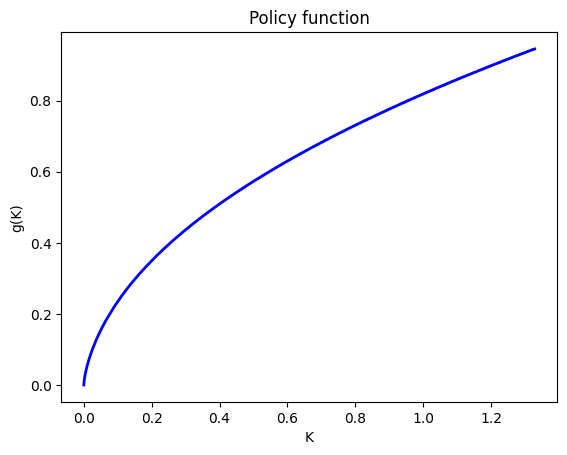

In [6]:
plt.plot(
    grid,
    policy_series[-1, :],
    color = "blue", linewidth=2
)
plt.xlabel("K")
plt.ylabel("g(K)")
plt.title("Policy function");

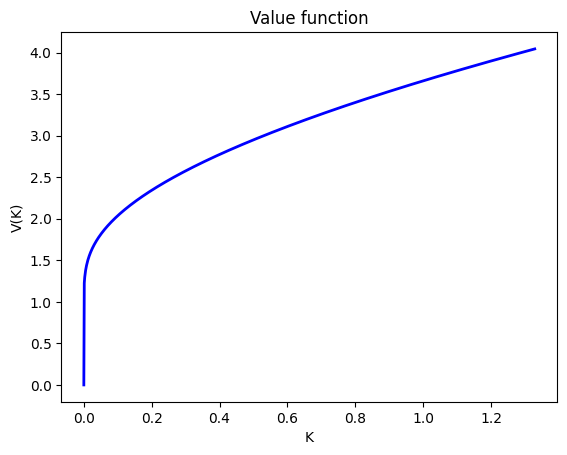

In [7]:
plt.plot(
    grid,
    V_series[-1, :],
    color = "blue", linewidth=2
)
plt.xlabel("K")
plt.ylabel("V(K)")
plt.title("Value function");

# **31 Policy Function Iteration**

In [8]:
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import bisect

In [9]:
def policy_function_iteration(
  F: Callable[[float, float], float],
  F_prime_x: Callable[[float, float], float],
  F_prime_y: Callable[[float, float], float],
  beta: float,
  grid: List[float],
  g0: List[float],
  constraint: Callable[[float], Tuple[float, float]],
  steady_x: float=None,
  convergence_eps: float=1e-6,
  max_iter=1000
):
  g_now = np.array(g0)
  g_next = np.zeros_like(g_now)
  g_series = g_now.reshape((1, -1))
  grid=np.array(grid)

  def FOC_equation(x):
    x_min, x_max = constraint(x)
    y = bisect(
      lambda y: F_prime_y(x, y) + beta*np.interp(y, grid, V_prime),
      1e-2,
      x_max
    )
    return y

  iter = 0
  while iter == 0 or np.max(np.abs(g_next - g_now)) > convergence_eps:
    g_now = g_series[-1, :]

    construct_V_prime = lambda x: F_prime_x(x[0], x[1])
    V_prime = np.apply_along_axis(
        construct_V_prime,
        0,
        np.concatenate(
            [grid.reshape((1, -1)), g_series[-1, :].reshape((1, -1))], axis=0
        )
    )

    vectorized_solver = np.vectorize(FOC_equation)
    g_next = vectorized_solver(grid)
    g_series = np.concatenate(
        [g_series, g_next.reshape((1, -1))], axis=0
    )

    iter += 1
    if iter % 50 == 0:
      print(f"Iteration {iter} has finished.")
    elif iter >= max_iter:
      break

  return g_series

In [10]:
sigma = 0.2
A = 1
alpha = 0.65
pk = 1
delta = 0.5
beta = 0.8
N = 200
eps = 1e-8

In [11]:
def U_prime(c):
  if c <= 0:
    return np.inf
  else:
    return c**(-sigma)


def F(x, y):
  if x <= 0 or A*(x**alpha) + pk*(1-delta)*x - pk*y <= 0:
    U = 0
  else:
    U = (1/(1-sigma))*((A*(x**alpha) + pk*(1-delta)*x - pk*y)**(1-sigma))
  return U

def F_prime_x(x, y):
  c = (A*(x**alpha)) + (pk*(1 - delta)*x) - (pk*y)
  return U_prime(c) * (A*alpha*(x**(alpha-1)) + (pk*(1 - delta)))

  return F_x

def F_prime_y(x, y):
  c = (A*(x**alpha)) + (pk*(1 - delta)*x) - (pk*y)
  return -U_prime(c)

def constraint(x):
  x_min = 0
  if x > 0:
    x_max = (A*(x**alpha))/pk + (1-delta)*x
  else:
    x_max = 0
  return (x_min, x_max)

steady_x = ((A*alpha)/(pk*((1/beta - 1) + delta)))**(1/(1-alpha))

grid = np.linspace(1e-3, steady_x, N).tolist()

g0 = (np.array(grid)).tolist()

g_series = policy_function_iteration(
  F=F,
  F_prime_x=F_prime_x,
  F_prime_y=F_prime_y,
  beta=beta,
  grid=grid,
  g0=g0,
  constraint=constraint,
  steady_x=steady_x,
  convergence_eps=eps,
  max_iter=200
)

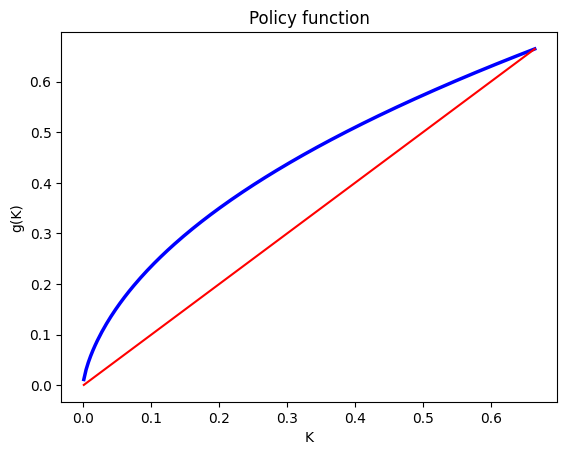

In [12]:
plt.plot(
    grid,
    g_series[-1, :],
    color = "blue", linewidth=2.5
)

plt.plot(
    grid, grid,
    color = "red", linewidth=1.5
)

plt.xlabel("K")
plt.ylabel("g(K)")
plt.title("Policy function");

# Transitional Dynamics

In [15]:
def F(x, y):
  if x <= 0 or A*(x**alpha) + (1-delta)*x - y <= 0:
    U = 0
  else:
    U = (1/(1-sigma))*((A*(x**alpha) + (1-delta)*x - y)**(1-sigma))

  return U


def constraint(x):
  x_min = 0
  if x > 0:
    x_max = (A*(x**alpha)) + (1-delta)*x
  else:
    x_max = 0
  return (x_min, x_max)

steady_x = ((A*alpha)/(((1/beta - 1) + delta)))**(1/(1-alpha))

grid = np.linspace(0, 2*steady_x, N).tolist()

V0 = np.array(grid).tolist()

V_series, policy_series = value_function_iteration(
  F=F,
  beta=beta,
  grid=grid,
  V0=V0,
  constraint=constraint,
  steady_x=steady_x,
  convergence_eps=eps,
  max_iter=1000
)

Iteration 50 has finished.


In [22]:
def Half_point(j, Policy_Function, K_ss):
    K_ss_half = K_ss/2
    i=j
    time=0
    while Policy_Function[-1][i] < K_ss_half:
        time = time+1
        i = i+1
    return time

## Write a function to calculate the half-life time (the number of periods that it takes to reach to half of the distance to the steady state. 

In [25]:
kgrid = np.linspace(0, steady_x, N).tolist()
time_list = []
for k in range(len(kgrid)):
    time_list.append(Half_point(k, policy_series, steady_x))

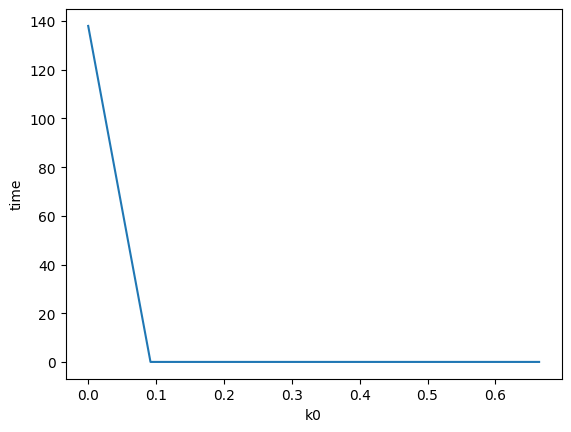

In [32]:

plt.plot(kgrid,time_list)
plt.xlabel('k0')
plt.ylabel('time')

plt.show()

## Write a function to calculate the number of periods that it takes to reach to 1% distance of the steady state.

In [34]:
def percent_99_point(j, Policy_Function, K_ss):
    K_ss_99 = 0.99* K_ss
    i=j
    time=0
    while Policy_Function[-1][i] < K_ss_99:
        time = time+1
        i = i+1
    return time

In [41]:
kgrid_99 = np.linspace(0, steady_x, N).tolist()
time_list_99 = []
for k in range(len(kgrid_99)):
    time_list_99.append(percent_99_point(k, policy_series, steady_x))

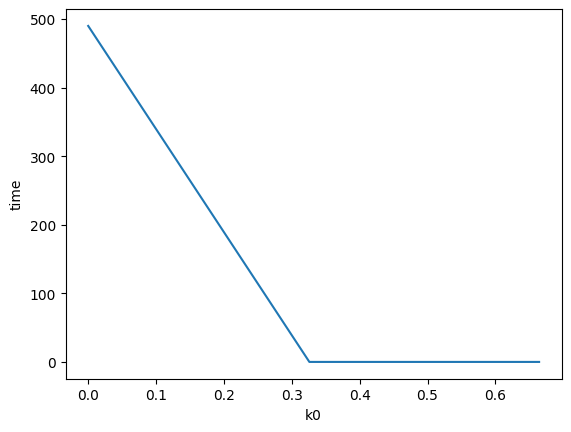

In [42]:

plt.plot(kgrid_99,time_list_99)
plt.xlabel('k0')
plt.ylabel('time')

plt.show()

# Consumption Saving

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.stats import uniform
import matplotlib.pyplot as plt
import math

In [21]:
# Utility function 1: logarithmic utility
def Utility_1(a_0, a_1, s, r, w):
    consumption = (1 + r) * a_0 + w * s - a_1
    return np.log(consumption) if consumption > 0 else -np.inf

# Utility function 2: CRRA utility
def Utility_2(a_0, a_1, s, r, w, gamma):
    consumption = (1 + r) * a_0 + w * s - a_1
    return (1/(1-gamma)) * (consumption) ** (1-gamma) if consumption > 0 else -np.inf

# Value Function Iteration for Utility 1
def VFI_1(r, w, beta, N, R, U, s_dist, tol, sigma):
    a_max = 10
    a_min = 0.0
    a_grid = np.linspace(a_min, a_max, N)
    np.random.seed(1403)
    s_grid = s_dist.rvs(size=R)

    # Function to calculate the feasible maximum next period asset
    def Gamma(a_0, s):
        feasible_a1 = (1 + r) * a_0 + w * s
        return max(min(feasible_a1, a_max), 0)

    V0 = np.zeros((N, R))
    dist = 1
    a_1 = np.zeros((N, R))
    V1 = np.zeros((N, R))
    interpolators = [interp1d(a_grid, V0[:, s], kind='linear', fill_value="extrapolate") for s in range(R)]

    def ExpectedValue(a, s):
        return interpolators[s](a)

    iteration = 0
    while dist > tol:
        for s in range(R):
            interpolators[s] = interp1d(a_grid, V0[:, s], kind='linear', fill_value="extrapolate")
            for i in range(N):
                def W(a_1):
                    return -(Utility_1(a_grid[i], a_1, s_grid[s], r, w) + beta * ExpectedValue(a_1, s))
                upper_bound = Gamma(a_grid[i], s_grid[s])
                if upper_bound > 0:  # Ensuring that the upper bound is greater than zero
                    res = minimize_scalar(W, bounds=(0, upper_bound), method='bounded')
                    a_1[i, s] = res.x
                    V1[i, s] = -W(a_1[i, s])
                #else:
                    #print(f"Skipped optimization due to non-positive upper bound: {upper_bound}")
        dist = np.max(np.abs(V1 - V0))
        V0, V1 = V1, np.zeros((N, R))
        iteration += 1
        #print(f"Iteration {iteration}, max distance {dist}")

    return V0, a_1, a_grid, s_grid


# Value Function Iteration for Utility 2
def VFI_2(r, w, beta, N, R, U, s_dist, tol, sigma):
    a_max = 10
    a_min = 0.0
    a_grid = np.linspace(a_min, a_max, N)
    np.random.seed(1403)
    s_grid = s_dist.rvs(size=R)

    # Function to calculate the feasible maximum next period asset
    def Gamma(a_0, s):
        feasible_a1 = (1 + r) * a_0 + w * s
        return max(min(feasible_a1, a_max), 0)

    V0 = np.zeros((N, R))
    dist = 1
    a_1 = np.zeros((N, R))
    V1 = np.zeros((N, R))
    interpolators = [interp1d(a_grid, V0[:, s], kind='linear', fill_value="extrapolate") for s in range(R)]

    def ExpectedValue(a, s):
        return interpolators[s](a)

    iteration = 0
    while dist > tol:
        for s in range(R):
            interpolators[s] = interp1d(a_grid, V0[:, s], kind='linear', fill_value="extrapolate")
            for i in range(N):
                def W(a_1):
                    return -(Utility_2(a_grid[i], a_1, s_grid[s], r, w, gamma) + beta * ExpectedValue(a_1, s))
                upper_bound = Gamma(a_grid[i], s_grid[s])
                if upper_bound > 0:  # Ensuring that the upper bound is greater than zero
                    res = minimize_scalar(W, bounds=(0, upper_bound), method='bounded')
                    a_1[i, s] = res.x
                    V1[i, s] = -W(a_1[i, s])
                #else:
                    #print(f"Skipped optimization due to non-positive upper bound: {upper_bound}")
        dist = np.max(np.abs(V1 - V0))
        V0, V1 = V1, np.zeros((N, R))
        iteration += 1
        #print(f"Iteration {iteration}, max distance {dist}")

    return V0, a_1, a_grid, s_grid


In [5]:
# Parameters and distribution instantiation
r = 0.2
sigma = 0.4
w = 1
beta = 0.93
N = 100
R = 50
tol = 1e-1
s_dist = uniform(0, 1)  

# Call VFI_1 function
V0, a_1, a_grid, s_grid = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)


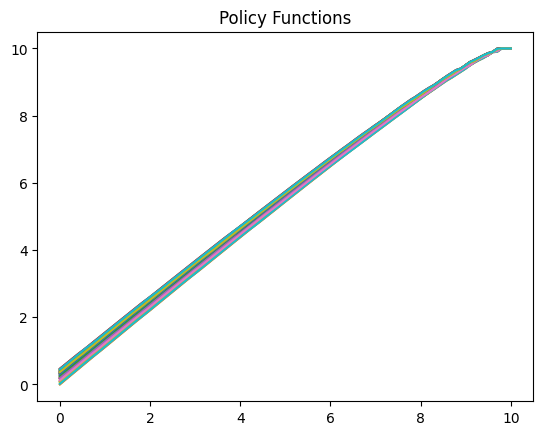

In [6]:

plt.plot(a_grid, a_1, label=None)
plt.title("Policy Functions")
plt.show()


## 2. Plot the policy and value functions for m = 1; 2; 3. How do results depend on the variance m?

in a uniform distribution we have:

$ \mu = \frac{a+b}{2}$

$\sigma = \frac{b-a}{\sqrt12}$

In [7]:
def shock_ab(m, sigma):
    # Adjusting the computation to ensure a minimum value of 0
    b = m + math.sqrt(3) * sigma
    a = m - math.sqrt(3) * sigma
    return max(a, 0), b


In [8]:

# Parameters for the model
m = 1
sigma = 0.5
r = 0.1
w = 1
beta = 0.85
N = 100
R = 10
tol = 1e-1

# Compute a and b from mean and standard deviation
a, b = shock_ab(m, sigma)

# Create uniform distribution with parameters a and b
s_dist = uniform(a, b)

V01, a_1_1, a_grid1, s_grid1 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)

In [9]:
# Parameters for the model
m = 2
sigma = 0.5
r = 0.1
w = 1
beta = 0.85
N = 100
R = 10
tol = 1e-1

# Compute a and b from mean and standard deviation
a, b = shock_ab(m, sigma)

# Create uniform distribution with parameters a and b
s_dist = uniform(a, b)

# Call the VFI function
V02, a_1_2, a_grid2, s_grid2 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)

In [10]:
# Parameters for the model
m = 3
sigma = 0.5
r = 0.1
w = 1
beta = 0.85
N = 100
R = 10
tol = 1e-1

# Compute a and b from mean and standard deviation
a, b = shock_ab(m, sigma)

# Create uniform distribution with parameters a and b
s_dist = uniform(a, b)

# Call the VFI function
V03, a_1_3, a_grid3, s_grid3 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)

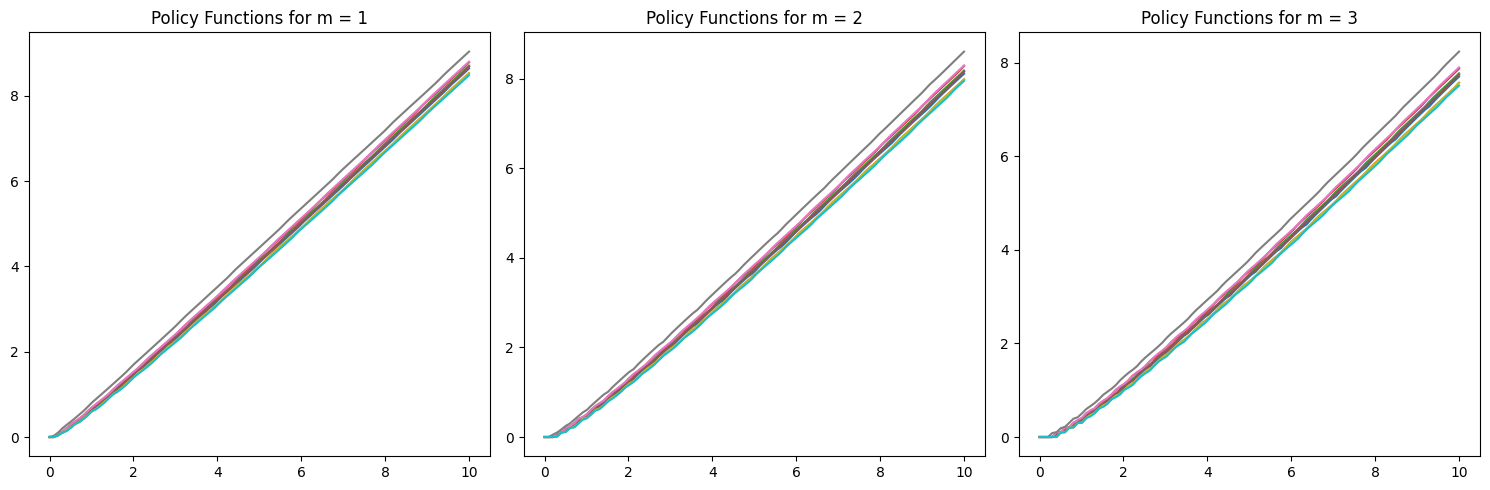

In [13]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(a_grid1, a_1_1, label=None)
axes[0].set_title('Policy Functions for m = 1')

axes[1].plot(a_grid2, a_1_2, label=None)
axes[1].set_title('Policy Functions for m = 2')

axes[2].plot(a_grid3, a_1_3, label=None)
axes[2].set_title('Policy Functions for m = 3')

plt.tight_layout()

# Display the plot
plt.show()


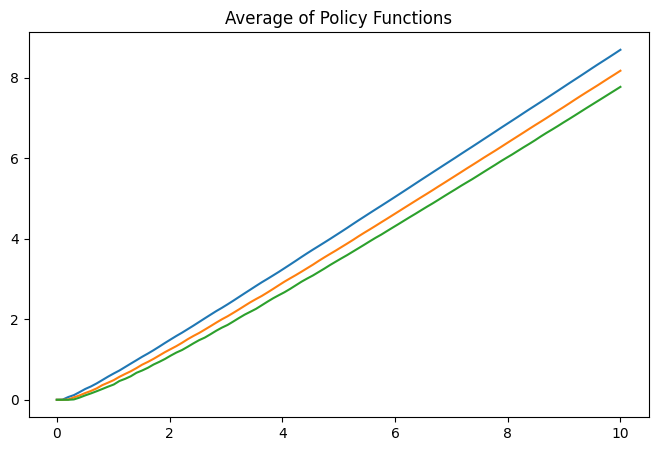

In [23]:

aprime1_mean = np.mean(a_1_1, axis=1)
aprime2_mean = np.mean(a_1_2, axis=1)
aprime3_mean = np.mean(a_1_3, axis=1)

plt.figure(figsize=(8, 5))  # Size in inches

# Plot for each set of grid and average aprime values
plt.plot(a_grid1, aprime1_mean, label="m = 1")
plt.plot(a_grid2, aprime2_mean, label="m = 2")
plt.plot(a_grid3, aprime3_mean, label="m = 3")


plt.title("Average of Policy Functions")  # Title of the plot
plt.show()  # Display the plot


As the mean of the shock increases, it indicates more favorable economic prospects, suggesting that the expected returns on investments will be higher, regardless of the shock variance. Consequently, the incentives to save are likely to increase. However, according to the income effect, higher household incomes also lead to increased consumption. Therefore, from the perspective of consumption smoothing, we anticipate an increase in both investment and current consumption as households adjust to maintain a stable level of utility over time.

## 3. Plot the policy and value functions for $\sigma=0.1, 0.2, 0.3$ How do results depend on the variance ? Explain in terms of the precautionary saving. Do we observe it here?

In [15]:
m = 1
sigma = 0.1
a, b = shock_ab(m, sigma)
s_dist = uniform(a, b)
V0_4, a_1_4, a_grid4, s_grid4 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)


In [16]:

m = 1
sigma = 0.2
a, b = shock_ab(m, sigma)
s_dist = uniform(a, b)
V0_5, a_1_5, a_grid5, s_grid5 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)


In [17]:

m = 1
sigma = 0.3
a, b = shock_ab(m, sigma)
s_dist = uniform(a, b)
V0_6, a_1_6, a_grid6, s_grid6 = VFI_1(r, w, beta, N, R, Utility_1, s_dist, tol, sigma)


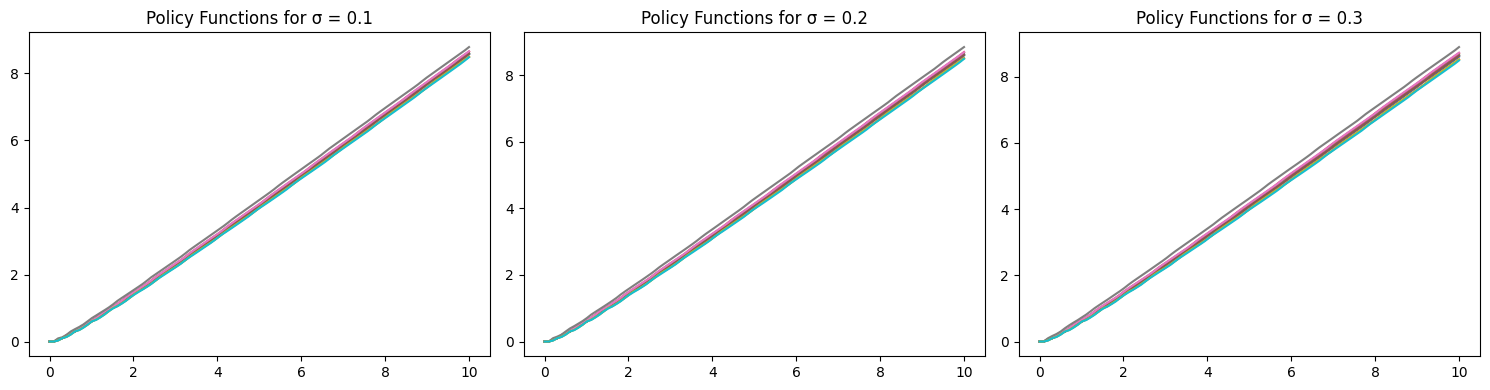

In [18]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(a_grid4, a_1_4)
axes[0].set_title("Policy Functions for σ = 0.1")


axes[1].plot(a_grid5, a_1_5)
axes[1].set_title("Policy Functions for σ = 0.2")


axes[2].plot(a_grid6, a_1_6)
axes[2].set_title("Policy Functions for σ = 0.3")

plt.tight_layout()

plt.show()


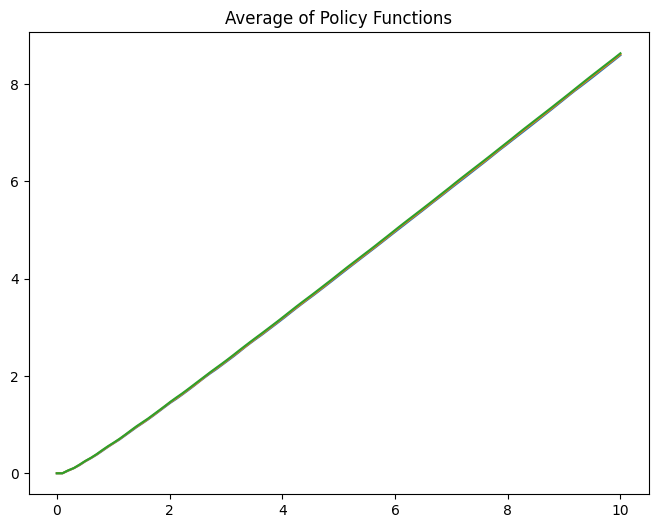

In [24]:

aprime4_mean = np.mean(a_1_4, axis=1)
aprime5_mean = np.mean(a_1_5, axis=1)
aprime6_mean = np.mean(a_1_6, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(a_grid4, aprime4_mean, label="σ = 0.1")
plt.plot(a_grid5, aprime5_mean, label="σ = 0.2")
plt.plot(a_grid6, aprime6_mean, label="σ = 0.3")


plt.title("Average of Policy Functions")
plt.show()


An increase in the variance of shocks indicates greater economic uncertainty. This occurs because the marginal cost of losing consumption outweighs the marginal benefit of increased consumption. People generally have a stronger aversion to losing consumption than they do to gaining it. As a result, they tend to boost their precautionary savings to mitigate potential risks.

## Change the utility function

In [22]:

m = 1
sigma = 0.3

a, b = shock_ab(m, sigma)
s_dist = uniform(a, b )
gamma = 0.2
V0_7, a_1_7, a_grid7, s_grid7 = VFI_2(r, w, beta, N, R, Utility_2, s_dist, tol, sigma)

gamma = 0.4
V0_8, a_1_8, a_grid8, s_grid8 = VFI_2(r, w, beta, N, R, Utility_2, s_dist, tol, sigma)

gamma = 0.8
V0_9, a_1_9, a_grid9, s_grid9 = VFI_2(r, w, beta, N, R, Utility_2, s_dist, tol, sigma)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


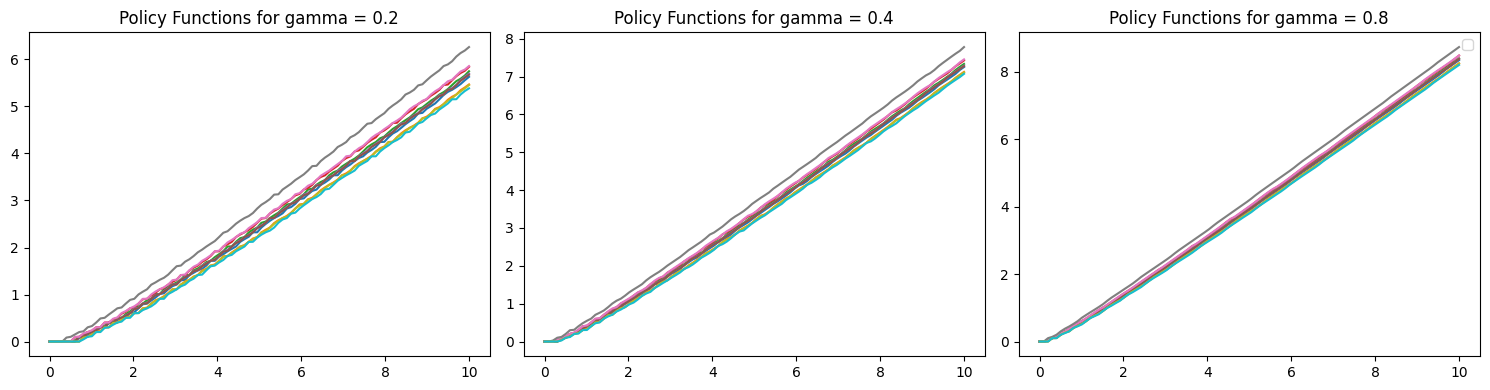

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(a_grid7, a_1_7)
axes[0].set_title("Policy Functions for gamma = 0.2")

axes[1].plot(a_grid8, a_1_8)
axes[1].set_title("Policy Functions for gamma = 0.4")

axes[2].plot(a_grid9, a_1_9)
axes[2].set_title("Policy Functions for gamma = 0.8")


plt.tight_layout()
plt.legend()
plt.show()

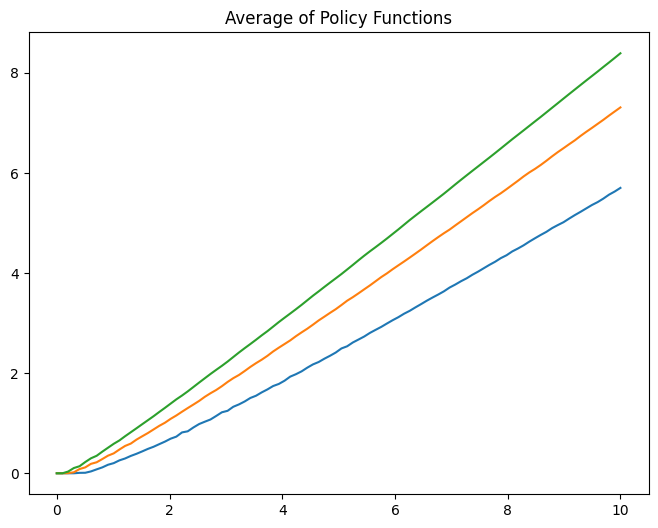

In [27]:
aprime7_mean = np.mean(a_1_7, axis=1)
aprime8_mean = np.mean(a_1_8, axis=1)
aprime9_mean = np.mean(a_1_9, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(a_grid7, aprime7_mean, label="gamma = 0.2")
plt.plot(a_grid8, aprime8_mean, label="gamma = 0.4")
plt.plot(a_grid9, aprime9_mean, label="gamma = 0.8")


plt.title("Average of Policy Functions")
plt.show()

As the parameter gamma increases, the concavity of the utility function becomes more pronounced. This heightened concavity signifies that individuals perceive a greater disutility from reductions in their consumption levels. Essentially, a higher gamma implies that the pain of losing a given amount of consumption is more severe than the pleasure derived from an equivalent gain. This sensitivity leads to an aversion to fluctuations in consumption, especially reductions.

Given this dynamic, we expect that as gamma rises, individuals will be motivated to bolster their precautionary savings. This increase in savings acts as a financial buffer, designed to mitigate the impact of potential downturns and stabilize consumption. By accumulating more savings, individuals aim to protect themselves against significant losses in marginal utility that could occur during economic downturns or other adverse conditions. This behavior aligns with the broader economic principle that as the risk or uncertainty of negative outcomes increases, so does the propensity to save in preparation for those potential scenarios.